In [27]:
import import_ipynb
import data_preprocessing
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import root_mean_squared_error, r2_score, accuracy_score, f1_score, confusion_matrix, roc_curve, auc
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import sklearn.model_selection
import time

In [28]:
# training data
u4_train_equil_turbine = data_preprocessing.u4_train_equil_turbine
u4_train_equil_pump = data_preprocessing.u4_train_equil_pump
u5_train_equil_turbine = data_preprocessing.u5_train_equil_turbine
u5_train_equil_pump = data_preprocessing.u5_train_equil_pump
u6_train_equil_turbine = data_preprocessing.u6_train_equil_turbine
u6_train_equil_pump = data_preprocessing.u6_train_equil_pump

# synethetic test sets
u5_s01_equil_turbine = data_preprocessing.u5_s01_equil_turbine
u5_s01_equil_pump = data_preprocessing.u5_s01_equil_pump
u5_s02_equil_turbine = data_preprocessing.u5_s02_equil_turbine
u5_s02_equil_pump = data_preprocessing.u5_s02_equil_pump
u6_s01_equil_turbine = data_preprocessing.u6_s01_equil_turbine
u6_s01_equil_pump = data_preprocessing.u6_s01_equil_pump
u6_s02_equil_turbine = data_preprocessing.u6_s02_equil_turbine
u6_s02_equil_pump = data_preprocessing.u6_s02_equil_pump

# real test sets
u4_test_equil_turbine = data_preprocessing.u4_test_equil_turbine
u4_test_equil_pump = data_preprocessing.u4_test_equil_pump
u5_test_equil_turbine = data_preprocessing.u5_test_equil_turbine
u5_test_equil_pump = data_preprocessing.u5_test_equil_pump
u6_test_equil_turbine = data_preprocessing.u6_test_equil_turbine
u6_test_equil_pump = data_preprocessing.u6_test_equil_pump

In [29]:
train_dataset = u5_train_equil_pump
test_dataset = u5_s01_equil_pump

In [30]:
features = ['tot_activepower', 'ext_tmp', 'plant_tmp', 'coupler_position', 'pump_calculated_flow', 
            'pump_pressure_diff', 'pump_rotspeed', 'turbine_pressure', 'turbine_rotspeed', 
            'water_primary_pump_01_opening', 'water_primary_pump_02_opening', 'turbine_cycle_id', 
            'pump_cycle_id', 'scaled_injector_sum',
            'hour_sin', 'hour_cos', 'dayofyear_sin', 'dayofyear_cos', 'dayofweek_sin', 'dayofweek_cos',
            # 'minute', 'hour', 'day', 'month', 'year', 'dayofweek', 'dayofyear',
            # 'tot_activepower_lag_1', 'tot_activepower_lag_3', 
            # 'tot_activepower_lag_10', 'ext_tmp_lag_1', 'ext_tmp_lag_3', 'ext_tmp_lag_10', 
            # 'plant_tmp_lag_1', 'plant_tmp_lag_3', 'plant_tmp_lag_10', 'coupler_position_lag_1', 
            # 'coupler_position_lag_3', 'coupler_position_lag_10', 'pump_calculated_flow_lag_1', 
            # 'pump_calculated_flow_lag_3', 'pump_calculated_flow_lag_10', 'pump_pressure_diff_lag_1', 
            # 'pump_rotspeed_lag_1', 'pump_rotspeed_lag_3', 'pump_rotspeed_lag_10', 'turbine_pressure_lag_1', 
            # 'turbine_pressure_lag_3', 'turbine_pressure_lag_10', 'turbine_rotspeed_lag_1', 
            # 'turbine_rotspeed_lag_3', 'turbine_rotspeed_lag_10', 'water_primary_pump_01_opening_lag_1', 
            # 'water_primary_pump_01_opening_lag_3', 'water_primary_pump_01_opening_lag_10', 
            # 'water_primary_pump_02_opening_lag_1', 'water_primary_pump_02_opening_lag_3', 
            # 'water_primary_pump_02_opening_lag_10', 'turbine_cycle_id_lag_1', 'turbine_cycle_id_lag_3', 
            # 'turbine_cycle_id_lag_10', 'pump_cycle_id_lag_1', 'pump_cycle_id_lag_3', 'pump_cycle_id_lag_10'
        ]


In [31]:
# Check if 'timer_turbine_on_off' is present; if not, exclude it from the feature list
features = [feature for feature in features if feature in train_dataset.columns]

target_features = ['charge', 'tot_current', 'tot_effectivepower', 'tot_reactivepower', 'air_circ_cold_01_tmp', 
    # 'air_circ_cold_02_tmp', 'air_circ_cold_03_tmp', 'air_circ_cold_04_tmp', 'air_circ_cold_05_tmp', 
    # 'air_circ_cold_06_tmp', 'air_circ_hot_01_tmp', 'air_circ_hot_02_tmp', 'air_circ_hot_03_tmp', 
    # 'air_circ_hot_04_tmp', 'air_circ_hot_05_tmp', 'air_circ_hot_06_tmp', 'elec_freq', 'exc_current', 
    # 'exc_voltage', 'mid_voltage', 'neutral_current', 'ph01_current', 'ph01_voltage', 'ph12_voltage', 
    # 'ph02_current', 'ph02_voltage', 'ph23_voltage', 'ph03_current', 'ph03_voltage', 'ph31_voltage', 
    # 'stat_coil_ph01_01_tmp', 'stat_coil_ph01_02_tmp', 'stat_coil_ph01_03_tmp', 'stat_coil_ph01_04_tmp', 
    # 'stat_coil_ph01_05_tmp', 'stat_coil_ph01_06_tmp', 'stat_coil_ph02_01_tmp', 'stat_coil_ph02_02_tmp', 
    # 'stat_coil_ph02_03_tmp', 'stat_coil_ph02_04_tmp', 'stat_coil_ph02_05_tmp', 'stat_coil_ph02_06_tmp', 
    # 'stat_coil_ph03_01_tmp', 'stat_coil_ph03_02_tmp', 'stat_coil_ph03_03_tmp', 'stat_coil_ph03_04_tmp', 
    # 'stat_coil_ph03_05_tmp', 'stat_coil_ph03_06_tmp', 'stat_magn_01_tmp', 'stat_magn_02_tmp', 
    # 'stat_magn_03_tmp', 'stat_magn_04_tmp', 'stat_magn_05_tmp', 'stat_magn_06_tmp', 'stat_magn_07_tmp', 
    # 'stat_magn_08_tmp', 'stat_magn_09_tmp', 'stat_magn_10_tmp', 'stat_magn_11_tmp', 'stat_magn_12_tmp', 
    # 'water_circ_cold_tmp', 'water_circ_flow', 'water_circ_hot_01_tmp', 'water_circ_hot_02_tmp', 
    # 'water_circ_hot_03_tmp', 'water_circ_hot_04_tmp', 'water_circ_hot_05_tmp', 'water_circ_hot_06_tmp', 
    # 'water_circ_hot_tmp', 'air_gap_negative_x_position', 'air_gap_positive_x_position', 
    # 'air_gap_negative_y_position', 'air_gap_positive_y_position'
    ]

# Split the data into source and target sets (we will regress the source variables onto the target variables)
train = train_dataset[features]
y = train_dataset[target_features]

In [32]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, window_size=50):
        """
        Custom Dataset for time series data
        
        Args:
        X (numpy.ndarray): Input features
        y (numpy.ndarray): Target features
        window_size (int): Size of the sliding window
        """
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)
        self.window_size = window_size
        
    def __len__(self):
        return max(0, self.X.size(0) - self.window_size + 1)
    
    def __getitem__(self, idx):
        # Create a sliding window of features
        x_window = self.X[idx:idx+self.window_size].T  # Transpose to make channels first
        y_window = self.y[idx+self.window_size-1]  # Last timestep's targets
        
        return x_window, y_window

In [33]:
class CNNRegressionModel(nn.Module):
    def __init__(self, 
                 input_size, 
                 target_size, 
                 window=50, 
                 n_ch=10, 
                 n_k=10, 
                 n_hidden=50, 
                 n_layers=5,
                 dropout=0.1,
                 padding='same'):
        """
        CNN Regression Model
        
        Args:
        input_size (int): Number of input features
        target_size (int): Number of target features to predict
        window (int): Size of input time window
        n_ch (int): Number of channels in convolutional layers
        n_k (int): Kernel size for convolutions
        n_hidden (int): Number of neurons in hidden layers
        n_layers (int): Number of classification layers
        dropout (float): Dropout rate
        padding (str): Padding type for convolutions
        """
        super(CNNRegressionModel, self).__init__()
        
        # Padding calculation
        pad = n_k // 2 if padding == 'same' else 0
        
        # Convolutional layers with batch normalization
        self.conv_layers = nn.ModuleList()
        current_channels = input_size
        for _ in range(3):
            conv_layer = nn.Sequential(
                nn.Conv1d(current_channels, n_ch, kernel_size=n_k, padding=pad),
                nn.BatchNorm1d(n_ch),
                nn.ReLU(),
                nn.MaxPool1d(2)
            )
            self.conv_layers.append(conv_layer)
            current_channels = n_ch
        
        # Calculate the flattened size dynamically
        with torch.no_grad():
            test_input = torch.zeros(1, input_size, window)
            conv_output = self._forward_convolutions(test_input)
            flattened_size = conv_output.numel()
        
        # Classification layers with dropout
        classification_layers = []
        layer_sizes = [flattened_size] + [n_hidden] * (n_layers - 1) + [target_size]
        for i in range(len(layer_sizes) - 1):
            classification_layers.extend([
                nn.Linear(layer_sizes[i], layer_sizes[i+1]),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
        # Remove the last dropout
        classification_layers = classification_layers[:-1]
        
        self.classification_layers = nn.Sequential(*classification_layers)
        
    def _forward_convolutions(self, x):
        """Helper method to apply convolutional layers"""
        for conv_layer in self.conv_layers:
            x = conv_layer(x)
        return x
    
    def forward(self, x):
        """Forward pass through the network"""
        x = self._forward_convolutions(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classification_layers(x)
        return x

In [34]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5, device='cuda'):
    """
    Train the CNN regression model with enhanced progress tracking
    
    Args:
    model (nn.Module): The neural network model
    train_loader (DataLoader): Training data loader
    val_loader (DataLoader): Validation data loader
    criterion (nn.Module): Loss function
    optimizer (torch.optim): Optimizer
    epochs (int): Number of training epochs
    device (str): Device to train on (cuda or cpu)
    
    Returns:
    tuple: Training and validation loss histories
    """
    model.to(device)
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        # Start timing the epoch
        epoch_start_time = time.time()
        
        # Training phase
        model.train()
        epoch_train_loss = 0.0
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item()
        
        # Validation phase
        model.eval()
        epoch_val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                epoch_val_loss += loss.item()
        
        # Calculate average losses
        avg_train_loss = epoch_train_loss / len(train_loader)
        avg_val_loss = epoch_val_loss / len(val_loader)
        
        # Record losses
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        # Calculate epoch duration
        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        
        # Print detailed epoch progress
        print(f'[Epoch {epoch+1}/{epochs}] '
              f'train_loss = {avg_train_loss:.5f}, '
              f'eval_loss = {avg_val_loss:.5f} '
              f'[{epoch_duration:.1f}s]')
    
    return train_losses, val_losses

In [35]:
def prepare_model_and_train(train, y, test_size=0.2, batch_size=32, random_state=42):
    """
    Prepare datasets, model, and train
    
    Args:
    train (pd.DataFrame): Training input features
    y (pd.DataFrame): Target features
    test_size (float): Proportion of validation set
    batch_size (int): Batch size for DataLoaders
    random_state (int): Random seed for reproducibility
    
    Returns:
    tuple: Trained model, train and validation losses
    """
    # Create the dataset
    dataset = TimeSeriesDataset(train, y)
    
    # Create indices for train and validation splits
    indices = list(range(len(dataset)))
    
    # Use sklearn's train_test_split for more robust splitting
    train_indices, val_indices = sklearn.model_selection.train_test_split(
        indices, test_size=test_size, random_state=random_state
    )
    
    # Create samplers
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)
    
    # Create DataLoaders
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)
    
    # Initialize the model
    model = CNNRegressionModel(
        input_size=train.shape[1], 
        target_size=y.shape[1], 
        window=50, 
        n_ch=10, 
        n_k=10, 
        n_hidden=50, 
        n_layers=5,
        dropout=0.1,
        padding='same'
    )
    
    # Define loss and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Train the model
    train_losses, val_losses = train_model(
        model, 
        train_loader, 
        val_loader, 
        criterion, 
        optimizer, 
        epochs=5, 
        device='cuda' if torch.cuda.is_available() else 'cpu'
    )
    
    return model, train_losses, val_losses

In [36]:
def plot_losses(train_losses, val_losses):
    """
    Plot training and validation losses
    
    Args:
    train_losses (list): Training losses per epoch
    val_losses (list): Validation losses per epoch
    """
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Model Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [37]:
model, train_losses, val_losses = prepare_model_and_train(train, y)

KeyboardInterrupt: 

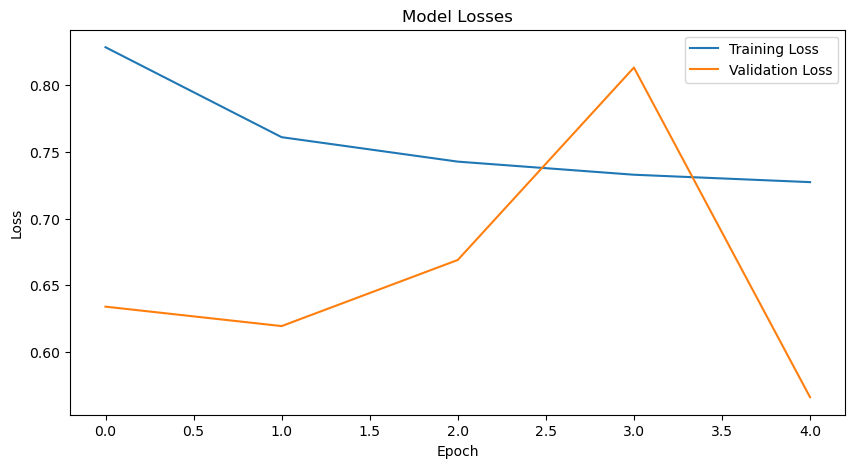

In [ ]:
plot_losses(train_losses, val_losses)

In [ ]:
# Predict on training data
train_loader = DataLoader(
    TimeSeriesDataset(train, y), batch_size=32, shuffle=False
)

model.eval()
y_pred_train = []
with torch.no_grad():
    for X_batch, _ in train_loader:
        X_batch = X_batch.to('cuda' if torch.cuda.is_available() else 'cpu')
        preds = model(X_batch)
        y_pred_train.append(preds.cpu().numpy())
y_pred_train = np.concatenate(y_pred_train, axis=0)

# Adjust y to match the reduced size due to the sliding window
adjusted_y = y.values[49:]  # Assuming window_size=50

# Compute residuals and norms for training data
residuals_train = adjusted_y - y_pred_train
residuals_norm_train = np.linalg.norm(residuals_train, axis=1)

# Threshold for anomaly detection
mean_norm = np.mean(residuals_norm_train)
std_norm = np.std(residuals_norm_train)
threshold = mean_norm + 6 * std_norm

In [ ]:
# Evaluate on test data
test = test_dataset[features]
y_test = test_dataset[target_features]

test_loader = DataLoader(
    TimeSeriesDataset(test, y_test), batch_size=32, shuffle=False
)

y_pred_test = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to('cuda' if torch.cuda.is_available() else 'cpu')
        preds = model(X_batch)
        y_pred_test.append(preds.cpu().numpy())
y_pred_test = np.concatenate(y_pred_test, axis=0)

adjusted_y_test = y_test.values[49:]  # Assuming window_size=50

# Compute residuals and norms for test data
residuals_test = adjusted_y_test - y_pred_test
residuals_norm_test = np.linalg.norm(residuals_test, axis=1)

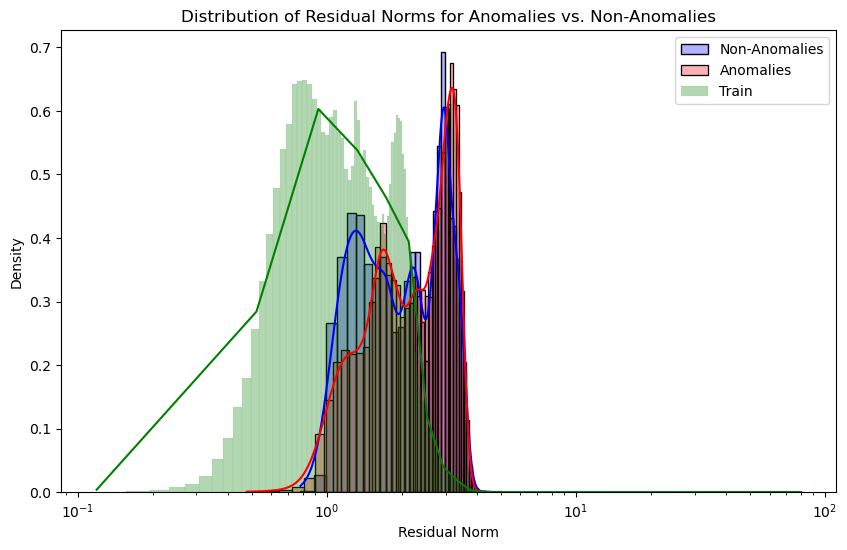

In [ ]:
# Plot distributions of residual norms
true_anomalies = test_dataset['anomaly']
adjusted_true_anomalies = true_anomalies.values[49:]  # Assuming window_size=50

anomalies = residuals_norm_test[adjusted_true_anomalies == 1]
non_anomalies = residuals_norm_test[adjusted_true_anomalies == 0]

plt.figure(figsize=(10, 6))
sns.histplot(non_anomalies, kde=True, color='blue', label='Non-Anomalies', stat='density', alpha=0.3)
sns.histplot(anomalies, kde=True, color='red', label='Anomalies', stat='density', alpha=0.3)
sns.histplot(residuals_norm_train, kde=True, color="green", label="Train", stat='density', alpha=0.3)

plt.xlabel('Residual Norm')
plt.ylabel('Density')
plt.title('Distribution of Residual Norms for Anomalies vs. Non-Anomalies')
plt.xscale('log')
plt.legend()
plt.show()


In [ ]:
# Compute ROC and AUC
fpr, tpr, thresholds = roc_curve(adjusted_true_anomalies, residuals_norm_test)
roc_auc = auc(fpr, tpr)

# Calculate F1-score for each threshold
f1_scores = []
for threshold in thresholds:
    predicted_anomalies = (residuals_norm_test >= threshold).astype(int)
    f1 = f1_score(adjusted_true_anomalies, predicted_anomalies)
    f1_scores.append(f1)

# Find best threshold
max_f1_index = np.argmax(f1_scores)
best_threshold = thresholds[max_f1_index]
max_f1 = f1_scores[max_f1_index]

print("Best Threshold:", best_threshold)
print("Max F1-score:", max_f1)
print("ROC AUC:", roc_auc)

Best Threshold: 0.47772456223670906
Max F1-score: 0.7777456448392206
ROC AUC: 0.551156758025304


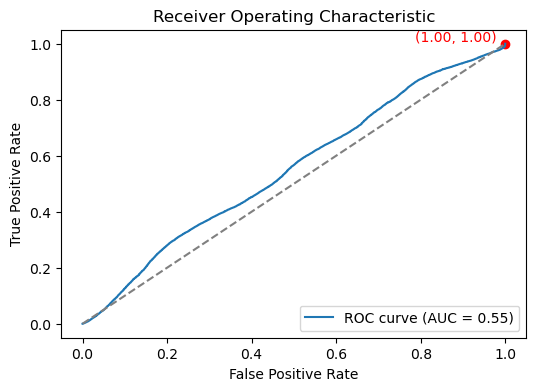

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.scatter(fpr[max_f1_index], tpr[max_f1_index], color='red')
plt.text(fpr[max_f1_index] - 0.02, tpr[max_f1_index] + 0.01, f"({fpr[max_f1_index]:.2f}, {tpr[max_f1_index]:.2f})",
         color='red', ha='right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

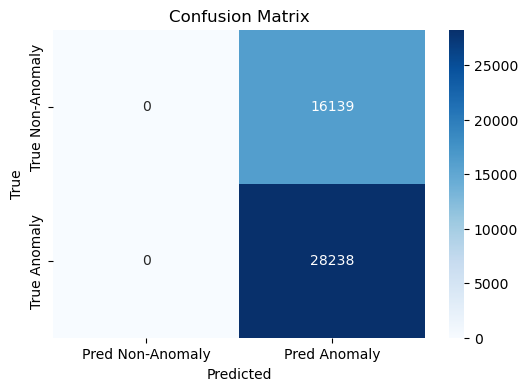

Accuracy: 0.6363206165355928
F1-score: 0.7777456448392206
R-squared: -0.5715348112472551


In [ ]:
# If want to train on 

# Confusion matrix and final metrics
predicted_anomalies = (residuals_norm_test >= best_threshold).astype(int)

accuracy = accuracy_score(adjusted_true_anomalies, predicted_anomalies)
f1 = f1_score(adjusted_true_anomalies, predicted_anomalies)
r2 = r2_score(adjusted_true_anomalies, predicted_anomalies)
cm = confusion_matrix(adjusted_true_anomalies, predicted_anomalies)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Pred Non-Anomaly', 'Pred Anomaly'], 
            yticklabels=['True Non-Anomaly', 'True Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("Accuracy:", accuracy)
print("F1-score:", f1)
print("R-squared:", r2)